In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import functions
from sklearn.preprocessing import StandardScaler

In [100]:
# Import data

#Matt's Data
kc = pd.read_csv('../../Data/matthew_clean_data.csv', index_col=0)
kc_trim = kc[kc['price'] < kc['price'].quantile(0.95)]

# Steve's data
s = pd.read_csv('../../Data/my_filtered_dataframe_id.csv', index_col=0)

# Tony's data
t = pd.read_csv('../../Data/cleanhousedata_id.csv', index_col=0)

# Merging all data on index
t.set_index('id')
kc.set_index('id')
kct = kc_trim.merge(t, on='id')
s.set_index('id')
all_clean = kct.merge(s, on='id')

# Cleaning up data, same way steve cleaned.
all_clean['view_y'].replace({ 'NONE': 0, 'FAIR': 1, 'AVERAGE': 2, 'GOOD': 3, 'EXCELLENT': 5}, inplace=True)
all_clean['view_y'] = all_clean['view_y'].astype('float')

# Dropping all copies, and columns with high multicolinearity
all_clean.drop(
    columns=['date_x', 'yr_renovated_x', 'waterfront', 'cat_waterfront', 'view_x', 'cat_view', 'cat_condition',
             'cat_grade', 'price_x', 'date_y', 'yr_renovated_y', 'price_y', 'floors_3.5', 'zipcode', 'id', 'cat_zipcode', 'bedrooms', 'yr_built_y', 'grade_y', 'floors_2.5', 'bathrooms', 'floors_2.0'], inplace=True)

# Final check of dataframe.
all_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18183 entries, 0 to 18182
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   grade_x      18183 non-null  int64  
 1   yr_built_x   18183 non-null  int64  
 2   floors_1.5   18183 non-null  int64  
 3   floors_3.0   18183 non-null  int64  
 4   sqft_living  18183 non-null  int64  
 5   sqft_lot     18183 non-null  int64  
 6   price        18183 non-null  float64
 7   condition    18183 non-null  int64  
 8   view_y       18183 non-null  float64
 9   lat          18183 non-null  float64
 10  long         18183 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 1.7 MB


## Model with Scaling

In [135]:
ss = StandardScaler()
X = all_clean.drop(columns=['price'])
colms = X.columns
y = all_clean['price']
X = pd.DataFrame(X, columns=colms)
X = ss.fit_transform(X)
# Placing back into a dataframe
X = pd.DataFrame(X, columns=colms)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
#model.summary()
model.summary2(float_format='%.4f')

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Ordinary least squares
=========================================================================
Model:                 OLS               Adj. R-squared:      0.600      
Dependent Variable:    price             AIC:                 312322.6249
Date:                  2021-10-07 13:20  BIC:                 312404.1098
No. Observations:      12182             Log-Likelihood:      -1.5615e+05
Df Model:              10                F-statistic:         1828.      
Df Residuals:          12171             Prob (F-statistic):  0.00       
R-squared:             0.600             Scale:               7.9725e+09 
-------------------------------------------------------------------------
               Coef.     Std.Err.    t     P>|t|     [0.025      0.975]  
-------------------------------------------------------------------------
const       404848.1860  809.0862 500.3771 0.0000 403262.2486 406434.1234
grade_x      54830.2000 1170.7797  46.8322 0.0000  52535.2858  57125.1142
yr_built_x  -21293.7256 1207.1988 -17.6390 0.0000 -23660.0272 -18927.4241
floors_1.5    4740.5244  879.4601   5.3903 0.0000   3016.6429   6464.4059
floors_3.0    4752.1227  874.6652   5.4331 0.0000   3037.6399   6466.6054
sqft_living  44715.4342 1079.2956  41.4302 0.0000  42599.8434  46831.0251
sqft_lot      6955.3043  940.1695   7.3979 0.0000   5112.4226   8798.1860
condition     9913.3190  847.4332  11.6981 0.0000   8252.2153  11574.4227
view_y       13584.7912  829.4602  16.3779 0.0000  11958.9173  15210.6650
lat          68716.0146  854.6705  80.4006 0.0000  67040.7246  70391.3046
long          7518.8021  928.0148   8.1020 0.0000   5699.7457   9337.8586
-------------------------------------------------------------------------
Omnibus:                178.417         Durbin-Watson:            1.996  
Prob(Omnibus):          0.000           Jarque-Bera (JB):         192.063
Skew:                   0.274           Prob(JB):                 0.000  
Kurtosis:               3.278           Condition No.:            3      
=========================================================================

"""

<AxesSubplot:title={'center':'Multiple Linear Regression Top Predictors'}, xlabel='Predictors', ylabel='Coefficient'>

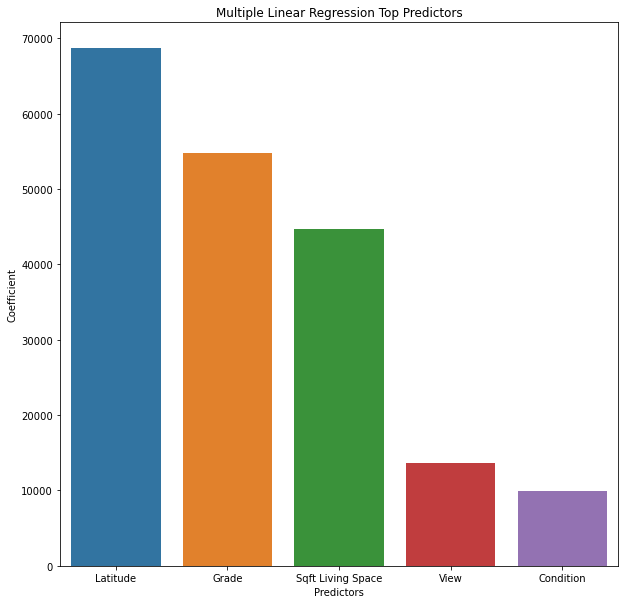

In [136]:
# Top model parameters
params = model.params.sort_values(ascending=False)

# Bar Graph of model parameters
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Multiple Linear Regression Top Predictors')
plt.xlabel('Predictors')
plt.ylabel('Coefficient')
pindex = ['Latitude', 'Grade', 'Sqft Living Space', 'View', 'Condition']
pvalues = params.values[1:6]
sns.barplot(x=pindex, y=pvalues);

In [102]:
# Model Predictions
train_preds = model.predict(sm.add_constant(X_train))
test_preds = model.predict(sm.add_constant(X_test))

# Evaluate R2, RMSE, and MAE
functions.evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.5949
Test R2: 0.6041
****
Train RMSE: $89,810.62
Test RMSE: $89,604.22
****
Train MAE: $70,844.87
Test MAE: $70,638.11


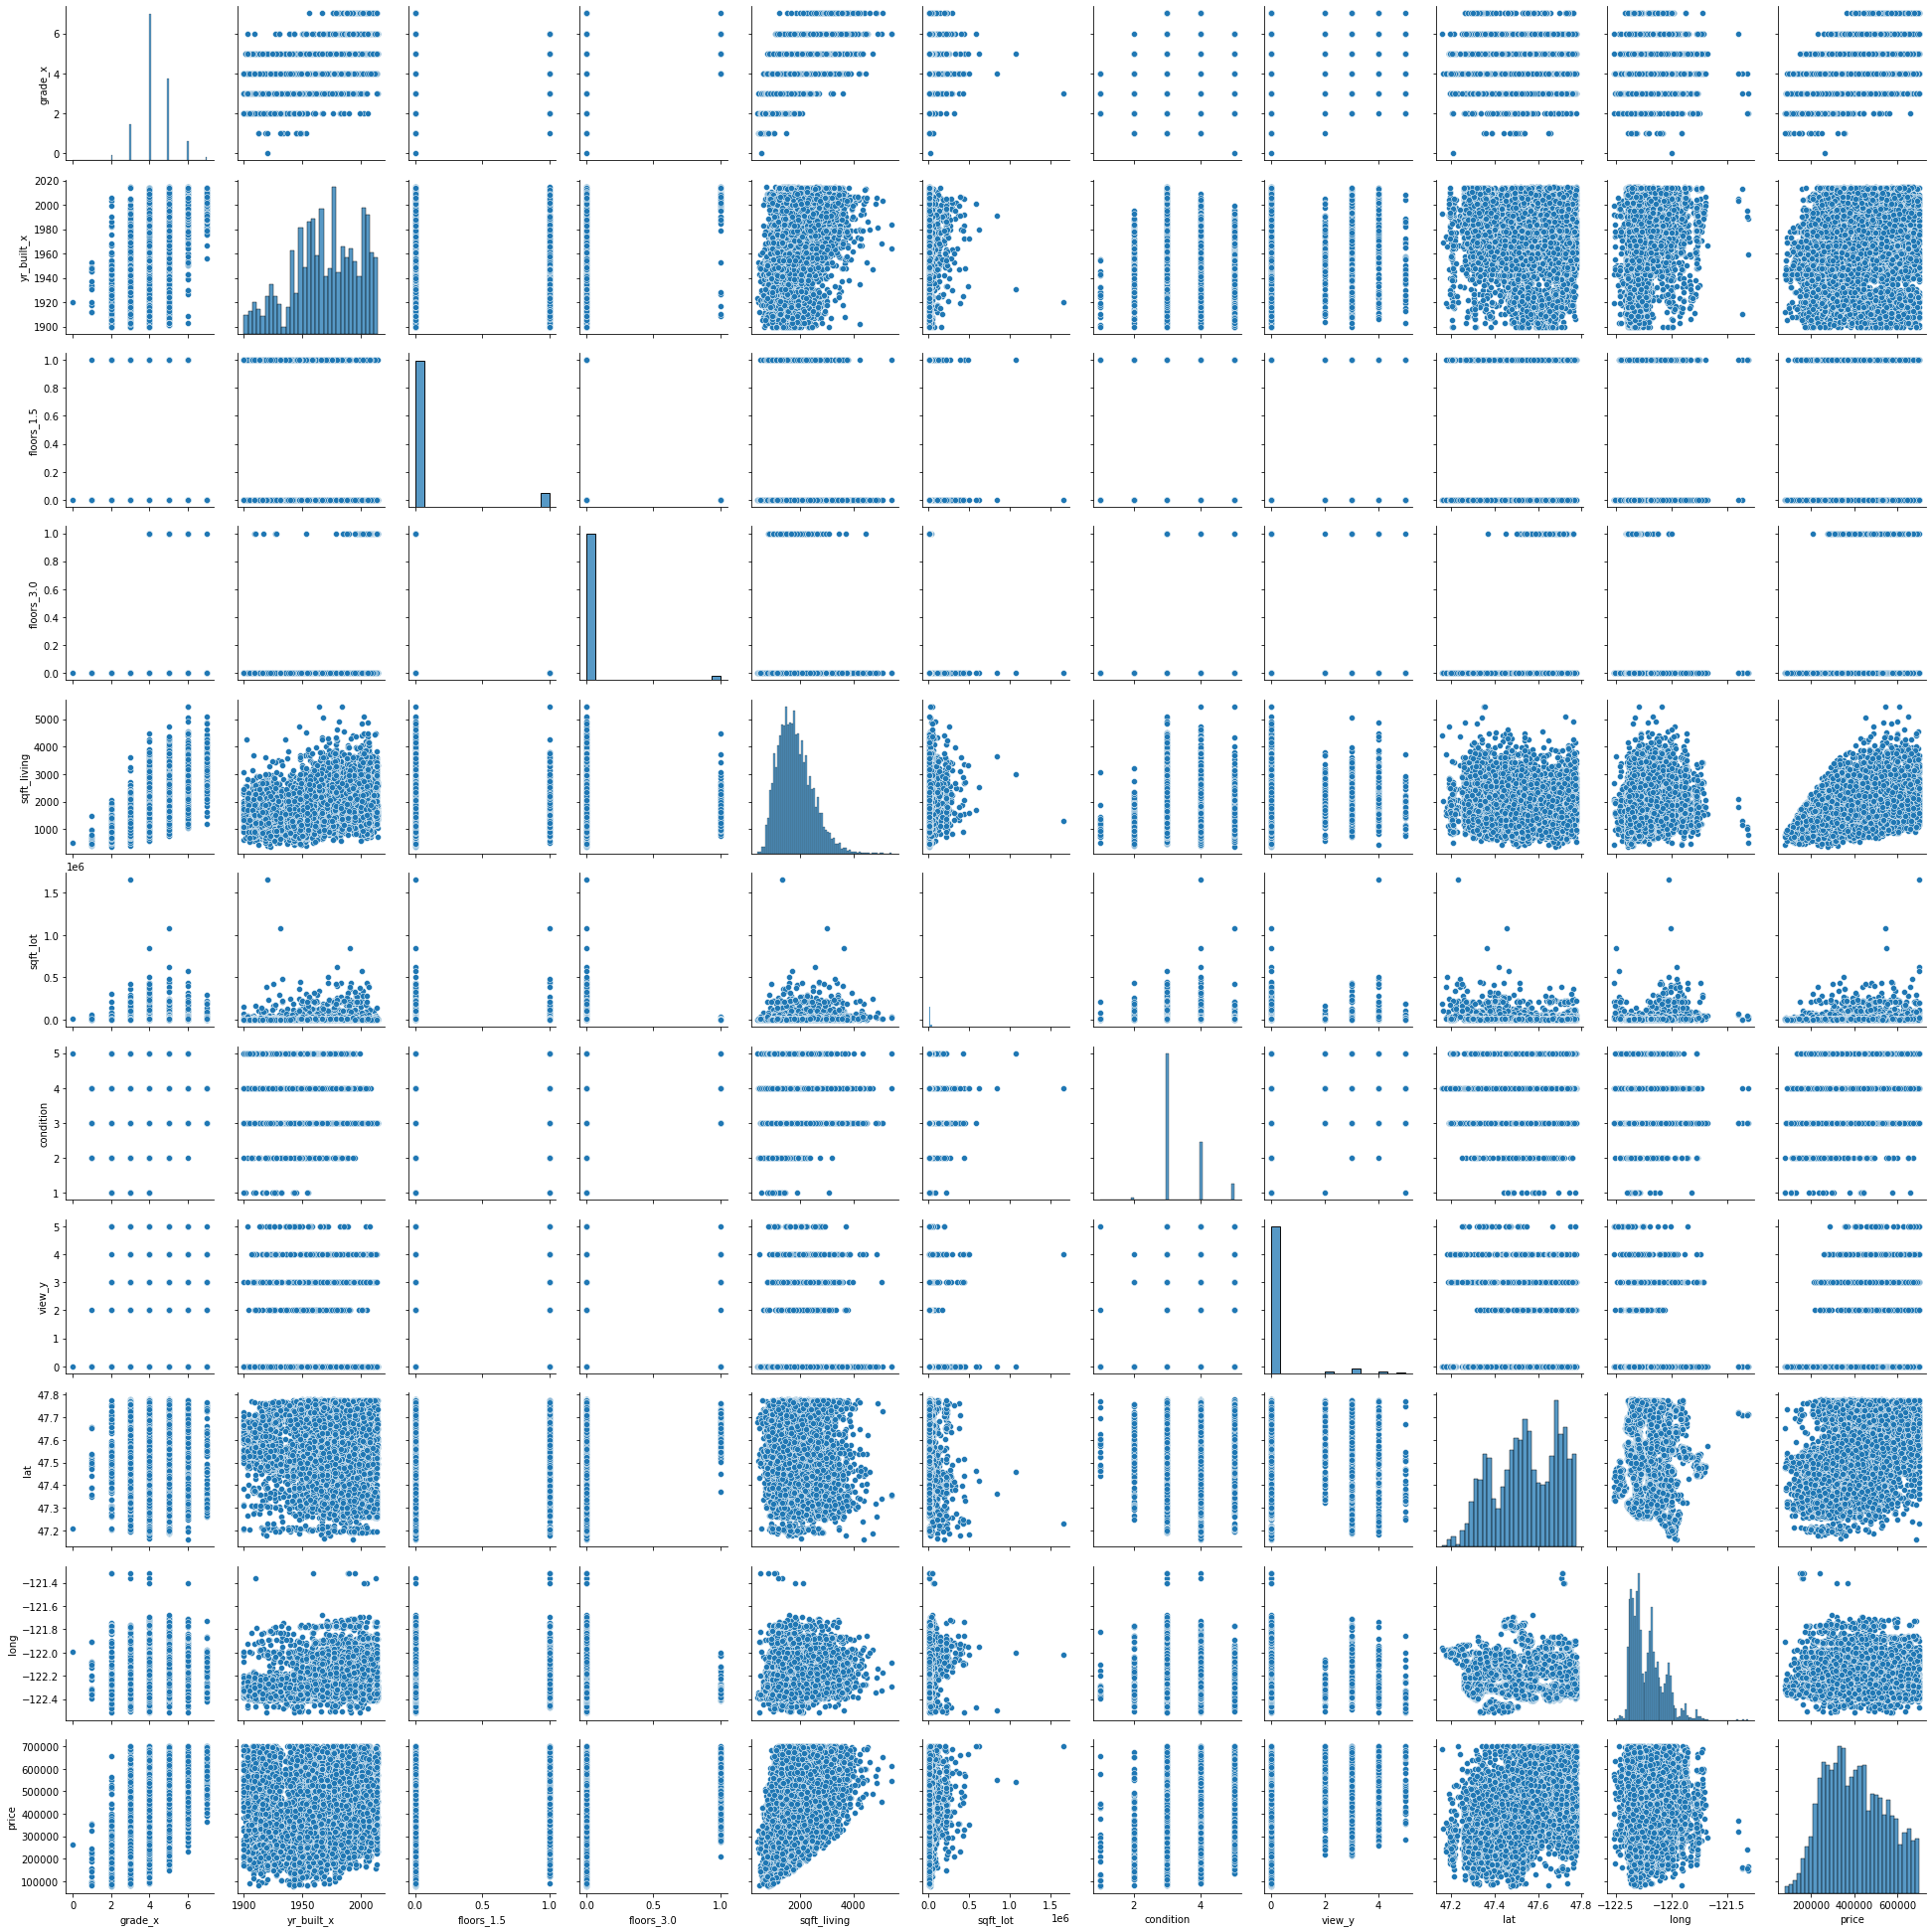

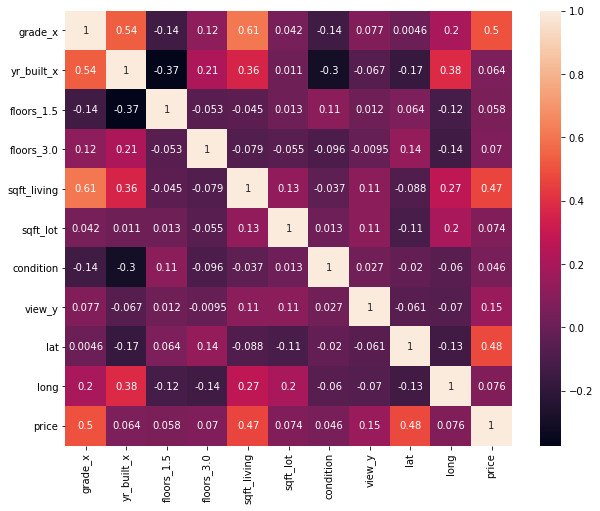

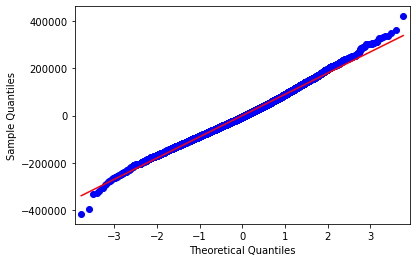

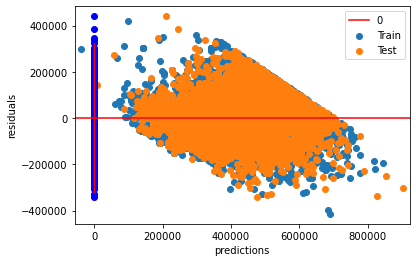

In [103]:
# Checking colinearity
functions.check_assumptions(X_train[colms], y_train, train_preds, test_preds, y_test)

## Conclusion
The model performs well, with an RMSE of around 88k.

However,

- There is an issue with colinearity in this model. grade and sqft_living for example are at 0.61 correlation.
- Errors are not heteroskedastic.

This model is a combination of the group's best models, but with some columns removed due to colinearity